In [1]:
import os
os.makedirs('src', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

with open('src/__init__.py', 'w') as f:
    pass

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import time
import numpy as np
import pandas as pd

In [4]:
if 'src' not in sys.path:
    sys.path.append(os.path.join(os.getcwd()))

In [5]:
from src.train import train_dqn_pid_tuner

In [6]:
print("\n--- Running Training Script (src/train.py) ---\n")
start_time = time.time()

try:
# This function executes the DQN training loop
    train_dqn_pid_tuner()
    end_time = time.time()
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")
except Exception as e:
    print(f"Training failed with error: {e}")


--- Running Training Script (src/train.py) ---

--- Starting DQN Training for PID Auto-Tuning ---


c:\Users\olale\Documents\ML\DQN\quadcopter-pid-dqn\.venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Ep:   10/500 | Reward:  -1100.98 | Avg R (10): -1926.71 | Kp/Kd: 5.50/3.00 | Epsilon: 0.9970
Ep:   20/500 | Reward:  -1147.71 | Avg R (10): -1281.79 | Kp/Kd: 5.50/4.00 | Epsilon: 0.9940
Ep:   30/500 | Reward: -12337.71 | Avg R (10): -2291.30 | Kp/Kd: 11.50/7.00 | Epsilon: 0.9910
Ep:   40/500 | Reward:  -4779.91 | Avg R (10): -4366.25 | Kp/Kd: 15.00/27.00 | Epsilon: 0.9881
Ep:   50/500 | Reward:   -754.19 | Avg R (10): -3265.60 | Kp/Kd: 38.50/31.00 | Epsilon: 0.9851
Ep:   60/500 | Reward:   -454.46 | Avg R (10): -529.23 | Kp/Kd: 48.50/36.00 | Epsilon: 0.9822
Ep:   70/500 | Reward:   -530.04 | Avg R (10): -477.27 | Kp/Kd: 42.00/41.50 | Epsilon: 0.9792
Ep:   80/500 | Reward:  -2943.50 | Avg R (10): -1875.67 | Kp/Kd: 18.00/30.00 | Epsilon: 0.9763
Ep:   90/500 | Reward:  -2807.53 | Avg R (10): -4727.40 | Kp/Kd: 5.00/33.50 | Epsilon: 0.9734
Ep:  100/500 | Reward:  -1340.30 | Avg R (10): -3771.53 | Kp/Kd: 1.00/32.00 | Epsilon: 0.9704
Ep:  110/500 | Reward:  -1348.35 | Avg R (10): -1381.21 | K

Analysis and Visualization

In [7]:
import matplotlib.pyplot as plt

In [8]:
log_path = 'results/training_log.csv'
if not os.path.exists(log_path):
    print(f"Error: Log file not found at {log_path}. Please check training execution.")
else:
    df = pd.read_csv(log_path)
print("Training log loaded successfully.")

Training log loaded successfully.


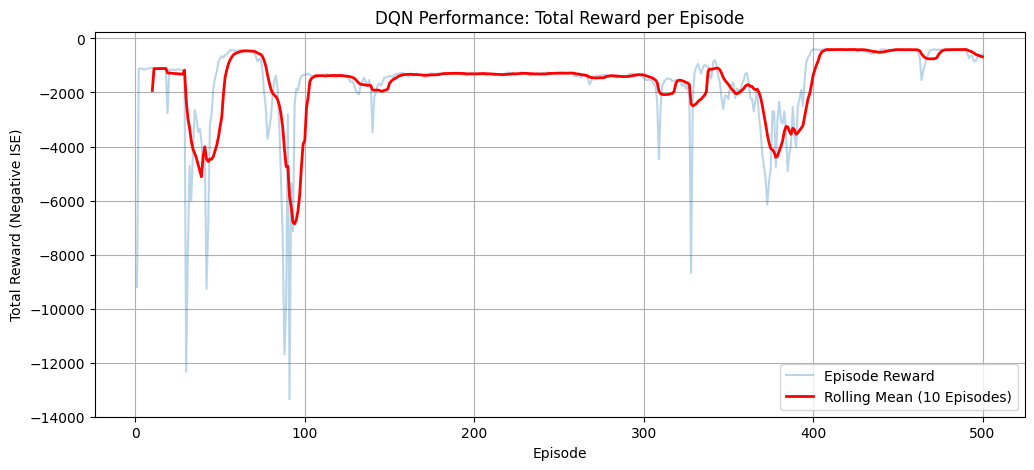

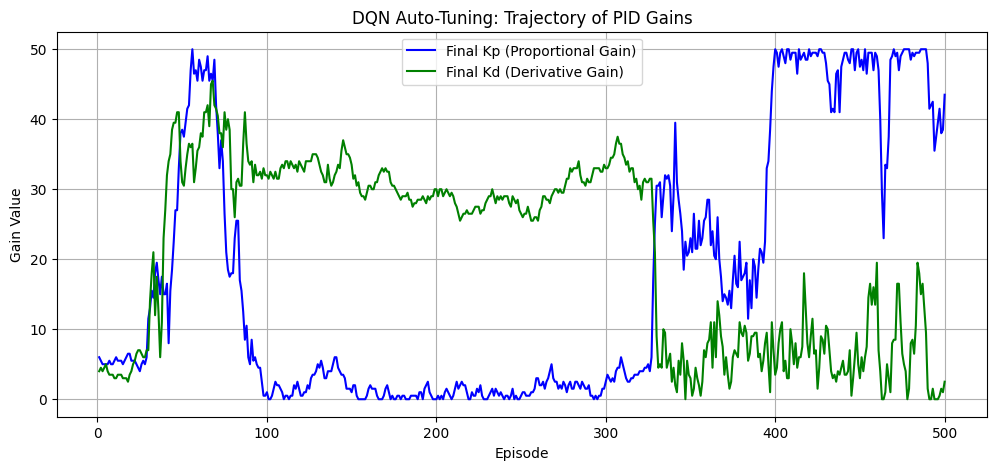


--- Final Optimized Gains ---
Learned Kp: 43.5000
Learned Kd: 2.5000


In [9]:
# Performance Metric Plot
plt.figure(figsize=(12, 5))
# Calculate a rolling mean for smoother visualization
df['rolling_reward'] = df['total_reward'].rolling(window=10).mean()
plt.plot(df['episode'], df['total_reward'], alpha=0.3, label='Episode Reward')
plt.plot(df['episode'], df['rolling_reward'], color='red', linewidth=2, label='Rolling Mean (10 Episodes)')
plt.title('DQN Performance: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward (Negative ISE)')
plt.grid(True)
plt.legend()
plt.show()

# Trajectory of Learned PID Gains Plot
plt.figure(figsize=(12, 5))
plt.plot(df['episode'], df['final_Kp'], label='Final Kp (Proportional Gain)', color='blue')
plt.plot(df['episode'], df['final_Kd'], label='Final Kd (Derivative Gain)', color='green')
plt.title('DQN Auto-Tuning: Trajectory of PID Gains')
plt.xlabel('Episode')
plt.ylabel('Gain Value')
plt.grid(True)
plt.legend()
plt.show()

final_Kp = df['final_Kp'].iloc[-1]
final_Kd = df['final_Kd'].iloc[-1]
print(f"\n--- Final Optimized Gains ---")
print(f"Learned Kp: {final_Kp:.4f}")
print(f"Learned Kd: {final_Kd:.4f}")


Testing: Simulation using the final learned Kp and Kd to observe the actual altitude trajectory.

In [13]:
from src.quadcopter_env import QuadcopterPIDA

if os.path.exists(log_path):
    test_Kp = float(df['final_Kp'].iloc[-1])
    test_Kd = float(df['final_Kd'].iloc[-1])
else:
    raise FileNotFoundError("Training log not found; cannot load final gains.")

print(f"Loaded final learned gains -> Kp={test_Kp:.4f}, Kd={test_Kd:.4f}")

Loaded final learned gains -> Kp=43.5000, Kd=2.5000


Testing with Kp=43.5000, Kd=2.5000


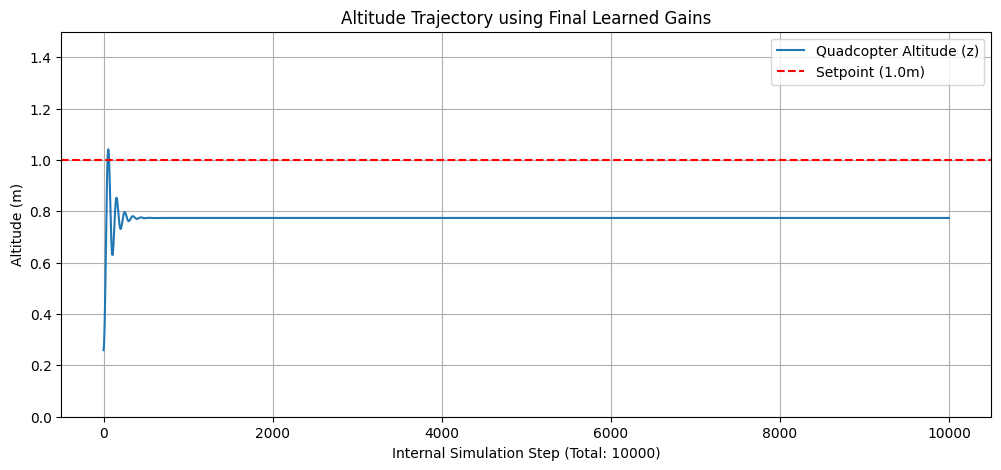

In [16]:
test_env = QuadcopterPIDA()
# Reset state
state, _ = test_env.reset()

test_env.pid_controller.set_gains(test_Kp, test_env.pid_controller.Ki, test_Kd)

print(f"Testing with Kp={test_Kp:.4f}, Kd={test_Kd:.4f}")

# Test Simulation
altitude_history = []

for rl_step in range(100):
    state, reward, terminated, truncated, info = test_env.step(4) 
    altitude_history.extend(info['altitude_history'])
    if terminated or truncated:
        break

# Plot the altitude trajectory
plt.figure(figsize=(12, 5))
plt.plot(altitude_history, label='Quadcopter Altitude (z)')
plt.axhline(y=test_env.pid_controller.setpoint, color='r', linestyle='--', label='Setpoint (1.0m)')
plt.title('Altitude Trajectory using Final Learned Gains')
plt.xlabel(f'Internal Simulation Step (Total: {len(altitude_history)})')
plt.ylabel('Altitude (m)')
plt.ylim(0, 1.5)
plt.legend()
plt.grid(True)
plt.show()

